## mAP (Mean Average Precision) 정리

#### 1. mAP (mean Average Precision)
먼저 용어해석을 통해 mAP 가 대략적인 의미를 알아보자.

- Precision 
    - 분류기의 성능평가지표로 사용하는 Precision-Recall 에서의 Precision과 같은 의미이다. 
    - 인식기 (object-detector) 가 검출한 정보들 중에서 Ground-Truth 와 일치하는 비율을 의미한다.  
- AP (Average Precision)
    - Recall value [0.0, 0.1, …, 1.0] 값들에 대응하는 Precision 값들의 Average 이다.  
- mAP (mean Average Precision) 
    - 1개의 object당 1개의 AP 값을 구하고, 여러 object-detector 에 대해서 mean 값을 구한 것이 mAP 이다  

#### *Precision & Recall
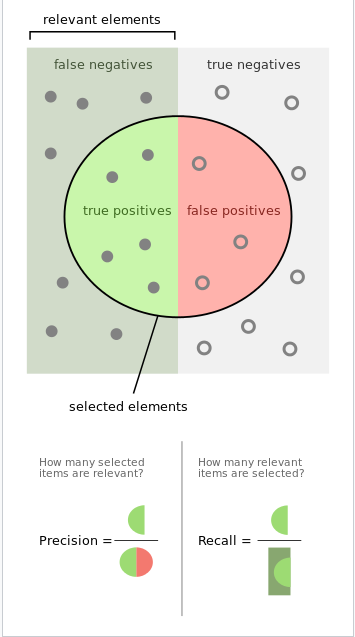

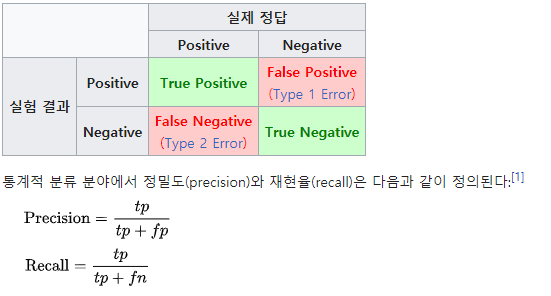

#### 2. mAP 를 구하는 방법
The PASCAL Visual Object Classes (VOC) Challenge (1) 수식에 보면 object detection 의 성능평가 지표로 mAP 를 어떻게 구하는 지가 나와있다. 

이를 토대로 구하는 순서를 정리해보자.


2.1 recall-precision 그래프를 그린다.

웹상에서 recall-precision 그래프에 대한 설명은 많이들 나와있다. 그러나 object-detection 과정에서 recall-precision 그래프를 어떻게 그리는지에 대해서는 자료를 찾기가 어려웠다. 

몇 가지 자료를 찾아보고 구현하기 위해 고민해본 결과 아래와 같은 Procedure 를 생각할 수 있었다.

- 1) Threshold 를 0으로 정해놓고 detection 알고리즘을 모든 test image 에 돌려본다.

    - 이 때 non-maximum-suppression 을 on 으로 설정하였다. 

    - 실제 Test Time 에서 객체를 검출할 떄 NMS 를 on 하고 operation 하기 때문에 이렇게 하는 것이 맞는 것 같다.



- 2) bounding-box 에 해당하는 confidence score (객체일 확률)과 true positive / false positive 여부를 Pair로 저장한다.

    - bounding-box 좌표는 필요없다.

    - true positive / false positive 는 검출영역과 Ground-Truth 영역간의 겹치는 영역 (overlapped region) 으로 판단한다.



if is true positive

else is false positive 

: prediction box

: ground truth box



- 3) (prob, ) pair 를 확률값에 따하 내림차순으로 정렬한다.

    - 이렇게 하면 아래와 같은 recall-precision 그래프를 그릴 수 있다. 그래프 그리는 과정은 Evaluation 11: interpolated recall-precision plot 를 참조하자.

2.2. Interpolated recall-precision 값 11개를 구한다.



- 위 수식에 따라 11개의 recall 값에 대한 precision 값을 구한다.

- 11개의 recall 값 : [0.0, 0.1, …, 1.0] 의 evenly-spaced 11-values



2.3. AP 를 구한다.

- 이 과정은 간단하다. 11개의 precision 값을 평균낸다. 수식으로 표현하면 아래와 같다.



2.4. mAP 를 구한다.

- 여기도 간단하다. 1개 object 에 대한 측정값이 AP 이므로 여러개의 object 에 대해 AP 를 구하고 평균내면 mAP 가 된다.


#### 3. Python 코드

In [1]:
#-*- coding: utf-8 -*-
import object_detector.file_io as file_io
import cv2
import numpy as np
import object_detector.utils as utils
import matplotlib.pyplot as plt
import progressbar
import pandas as pd

class Evaluator(object):
    
    def __init__(self):
        self._recall_precision = None
        self._dataset = None
    
    def eval_average_precision(self, test_image_files, 
                               annotation_path, 
                               detector, 
                               window_dim, window_step, pyramid_scale):
        
        """Public function to calculate average precision of the detector.
        Parameters
        ----------
        test_image_files : list of str
            list of test image filenames to evaluate detector's performance
    
        annotation_path : str
            annotation directory path for test_image_files
        
        detector : Detector
            instance of Detector class
        
        window_dim : list
            (height, width) order of sliding window size
            
        window_step : list
            (height_step, width_step) order of sliding window step
            
        pyramid_scale : float
            scaling ratio of building image pyramid
            
        Returns
        ----------
        average_precision : float
            evaluated score for the detector and test images on average precision. 
    
        Examples
        --------
        """
        
        patches = []
        probs = []
        gts = []
        
        # setup the progress bar
        widgets = ["Running for each Test image as gathering patches and its probabilities: ", 
                   progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
        pbar = progressbar.ProgressBar(maxval=len(test_image_files), widgets=widgets).start()
        
        for i, image_file in enumerate(test_image_files):
            test_image = cv2.imread(image_file)
            test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

            boxes, probs_ = detector.run(test_image, 
                                         window_dim, window_step, pyramid_scale, 
                                         threshold_prob=0.0,
                                         show_result=False, 
                                         show_operation=False)
              
            truth_bb = self._get_truth_bb(image_file, annotation_path)
            ious = self._calc_iou(boxes, truth_bb)
            is_positive = ious > 0.5
             
            patches += boxes.tolist()
            probs += probs_.tolist()
            gts += is_positive.tolist()
            
            pbar.update(i)
        pbar.finish()
    
        probs = np.array(probs)
        gts = np.array(gts)

        self._calc_precision_recall(probs, gts)
        average_precision = self._calc_average_precision()
        
        return average_precision
    
    def plot_recall_precision(self):
        """Function to plot recall-precision graph.
        
        It should be performed eval_average_precision() before this function is called.
        """
        range_offset = 0.1
        
        if self._recall_precision is None:
            raise ValueError('Property _recall_precision is not calculated. To calculate this, run eval_average_precision() first.')
        
        recall_precision = self._recall_precision
        
        plt.plot(recall_precision[:, 0], recall_precision[:, 1], "r-")
        plt.plot(recall_precision[:, 0], recall_precision[:, 1], "ro")
        plt.axis([0 - range_offset, 1 + range_offset, 0 - range_offset, 1 + range_offset])
        plt.xlabel("recall")
        plt.ylabel("precision")
        plt.show()
    
    @property
    def dataset(self):
        if self._dataset is None:
            raise ValueError('Property _dataset is not calculated. To calculate this, run eval_average_precision() first.')
    
        d = {"probability": self._dataset[:,0], 'ground truth': self._dataset[:,1].astype(np.bool_)}
        df = pd.DataFrame(data=d, columns = ["probability", 'ground truth'])
        return df
    
    def _calc_average_precision(self):
        
        inter_precisions = []
        for i in range(11):
            recall = float(i) / 10
            inter_precisions.append(self._calc_interpolated_precision(recall))
            
        return np.array(inter_precisions).mean()

    
    def _calc_precision_recall(self, probs, ground_truths):
        probs = np.array(probs)
        ground_truths = np.array(ground_truths)
        
        dataset = np.concatenate([probs.reshape(-1,1), ground_truths.reshape(-1,1)], axis=1)
        dataset = dataset[dataset[:, 0].argsort()[::-1]]
        
        n_gts = len(dataset[dataset[:, 1] == 1])
        n_relevant = 0.0
        n_searched = 0.0
        
        recall_precision = []
        
        for data in dataset:
            n_searched += 1
            if data[1] == 1:
                n_relevant += 1
            recall = n_relevant / n_gts
            precision = n_relevant / n_searched
            recall_precision.append((recall, precision))
            
            if recall == 1.0:
                break
        
        self._dataset = dataset
        self._recall_precision = np.array(recall_precision)
    
    def _calc_interpolated_precision(self, desired_recall):
        recall_precision = self._recall_precision
        
        inter_precision = recall_precision[recall_precision[:,0] >= desired_recall]
        inter_precision = inter_precision[:, 1]
        inter_precision = max(inter_precision)
        return inter_precision
    
    def _calc_iou(self, boxes, truth_box):
        y1 = boxes[:, 0]
        y2 = boxes[:, 1]
        x1 = boxes[:, 2]
        x2 = boxes[:, 3]
        
        y1_gt = truth_box[0]
        y2_gt = truth_box[1]
        x1_gt = truth_box[2]
        x2_gt = truth_box[3]
        
        xx1 = np.maximum(x1, x1_gt)
        yy1 = np.maximum(y1, y1_gt)
        xx2 = np.minimum(x2, x2_gt)
        yy2 = np.minimum(y2, y2_gt)
    
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        intersections = w*h
        As = (x2 - x1 + 1) * (y2 - y1 + 1)
        B = (x2_gt - x1_gt + 1) * (y2_gt - y1_gt + 1)
        
        ious = intersections.astype(float) / (As + B -intersections)
        return ious


    # Todo : extractor module과 중복되는 내용 제거
    def _get_truth_bb(self, image_file, annotation_path):
        image_id = utils.get_file_id(image_file)
        annotation_file = "{}/annotation_{}.mat".format(annotation_path, image_id)
        bb = file_io.FileMat().read(annotation_file)["box_coord"][0]
        return bb

ModuleNotFoundError: No module named 'object_detector'

#### 4. 정리


장점 1: 인식 threshold 에 의존성없이 성능평가가 가능하다.

장점 2: mAP 평가를 통해 최적 threshold 를 정할 수 도 있다.

단점 : 굉장히 느리다. 아무래도 모든 Test Image 에서 Threshold 0 이상의 box 를 추출하고 정렬하는 과정을 거쳐야 하므로…

